RandomForest - Default Test Accuracy: 0.6375
RandomForest - Cross-validated Accuracy: 0.6873
RandomForest - Random Search Best CV Accuracy: 0.6904
RandomForest - Random Search Test Accuracy: 0.6594
RandomForest - Random Search - Best Params: {'classifier__max_depth': 44, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 838, 'preprocessor__cat__onehot__active': True, 'preprocessor__num__log_transform__active': True, 'preprocessor__num__scaler__active': False}
RandomForest - Bayesian Search Best CV Accuracy: 0.6928
RandomForest - Bayesian Search Test Accuracy: 0.6562
RandomForest - Bayesian Search - Best Params: OrderedDict([('classifier__max_depth', 100), ('classifier__min_samples_leaf', 1), ('classifier__n_estimators', 1000), ('preprocessor__cat__onehot__active', True), ('preprocessor__num__log_transform__active', True), ('preprocessor__num__scaler__active', False)])
GradientBoosting - Default Test Accuracy: 0.6156
GradientBoosting - Cross-validated Accuracy: 0.6505
Gradi

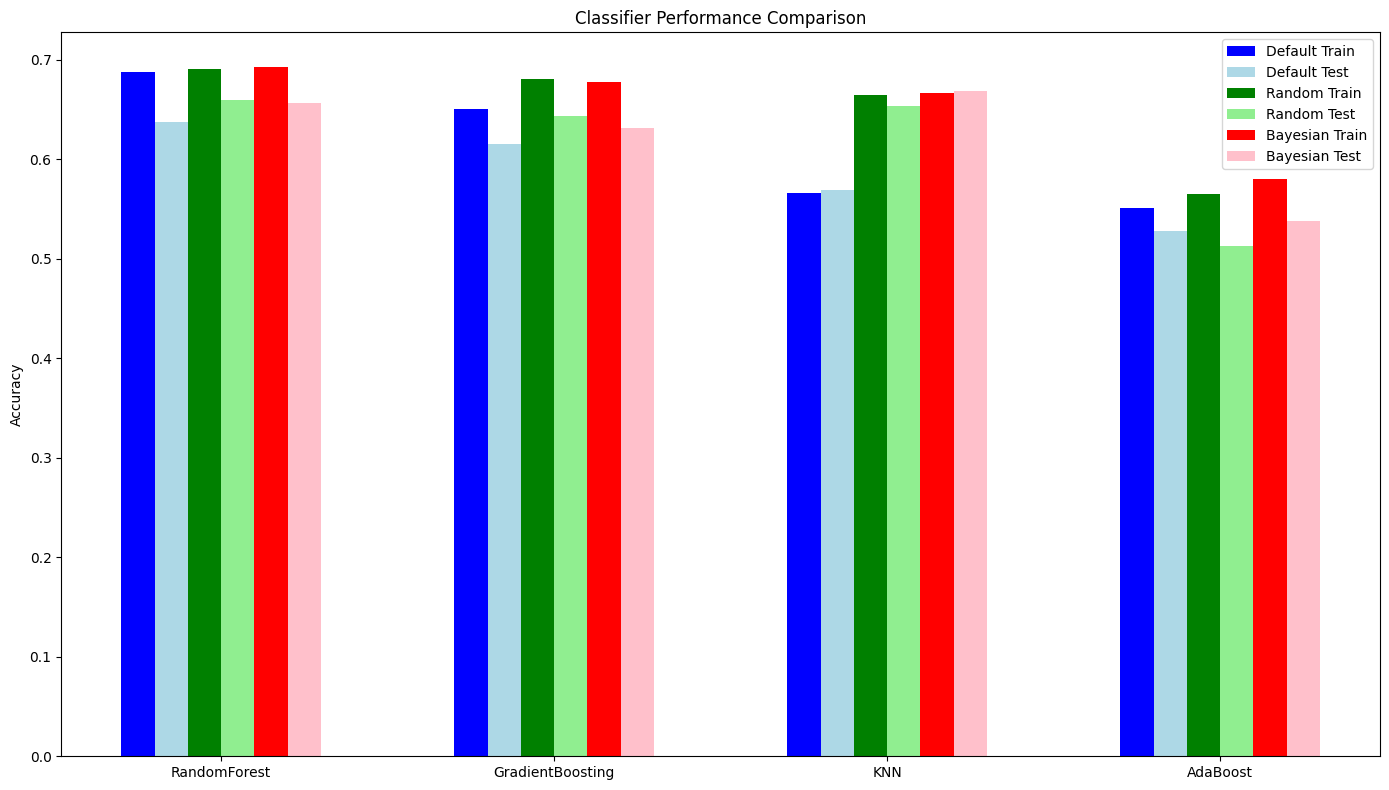

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import randint, uniform

df = pd.read_csv('winequality-red.csv')
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def log_transform(X):
    return np.log1p(X)

class OptionalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, active=True):
        self.transformer = transformer
        self.active = active

    def fit(self, X, y=None):
        return self.transformer.fit(X, y) if self.active else self

    def transform(self, X):
        return self.transformer.transform(X) if self.active else X

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline([
    ('log_transform', OptionalTransformer(FunctionTransformer(log_transform, validate=False))),
    ('scaler', OptionalTransformer(StandardScaler()))
])

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = Pipeline([
    ('onehot', OptionalTransformer(OneHotEncoder(handle_unknown='ignore')))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', None)
])

classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

search_spaces = {
    'RandomForest': {
        'classifier__n_estimators': Integer(100, 1000),
        'classifier__max_depth': Integer(10, 100),
        'classifier__min_samples_leaf': Integer(1, 20),
        'preprocessor__num__log_transform__active': Categorical([True, False]),
        'preprocessor__num__scaler__active': Categorical([True, False]),
        'preprocessor__cat__onehot__active': Categorical([True, False])
    },
    'GradientBoosting': {
        'classifier__n_estimators': Integer(50, 300),
        'classifier__learning_rate': Real(0.01, 0.2),
        'classifier__max_depth': Integer(1, 10),
        'classifier__min_samples_leaf': Integer(1, 10),
        'preprocessor__num__log_transform__active': Categorical([True, False]),
        'preprocessor__num__scaler__active': Categorical([True, False]),
        'preprocessor__cat__onehot__active': Categorical([True, False])
    },
    'KNN': {
        'classifier__n_neighbors': Integer(1, 30),
        'classifier__weights': Categorical(['uniform', 'distance']),
        'classifier__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
        'preprocessor__num__log_transform__active': Categorical([True, False]),
        'preprocessor__num__scaler__active': Categorical([True, False]),
        'preprocessor__cat__onehot__active': Categorical([True, False])
    },
    'AdaBoost': {
        'classifier__n_estimators': Integer(50, 100),
        'classifier__learning_rate': Real(0.1, 1.0),
        'preprocessor__num__log_transform__active': Categorical([True, False]),
        'preprocessor__num__scaler__active': Categorical([True, False]),
        'preprocessor__cat__onehot__active': Categorical([True, False])
    }
}

random_search_spaces = {
    'RandomForest': {
        'classifier__n_estimators': randint(100, 1000),
        'classifier__max_depth': randint(10, 100),
        'classifier__min_samples_leaf': randint(1, 20),
        'preprocessor__num__log_transform__active': [True, False],
        'preprocessor__num__scaler__active': [True, False],
        'preprocessor__cat__onehot__active': [True, False]
    },
    'GradientBoosting': {
        'classifier__n_estimators': randint(50, 500),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(1, 10),
        'classifier__min_samples_leaf': randint(1, 10),
        'preprocessor__num__log_transform__active': [True, False],
        'preprocessor__num__scaler__active': [True, False],
        'preprocessor__cat__onehot__active': [True, False]
    },
    'KNN': {
        'classifier__n_neighbors': randint(1, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'preprocessor__num__log_transform__active': [True, False],
        'preprocessor__num__scaler__active': [True, False],
        'preprocessor__cat__onehot__active': [True, False]
    },
    'AdaBoost': {
        'classifier__n_estimators': randint(50, 100),
        'classifier__learning_rate': uniform(0.1, 1.0),
        'preprocessor__num__log_transform__active': [True, False],
        'preprocessor__num__scaler__active': [True, False],
        'preprocessor__cat__onehot__active': [True, False]
    }
}

results = {}
for model_name, classifier in classifiers.items():
    pipeline.set_params(classifier=classifier)
    pipeline.fit(X_train, y_train)
    default_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
    default_cv_accuracy = np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy'))
    print(f"{model_name} - Default Test Accuracy: {default_accuracy:.4f}")
    print(f"{model_name} - Cross-validated Accuracy: {default_cv_accuracy:.4f}")



    rand_search = RandomizedSearchCV(pipeline, param_distributions=random_search_spaces[model_name], n_iter=30, cv=5, scoring='accuracy', random_state=42)
    rand_search.fit(X_train, y_train)
    rand_best_estimator = rand_search.best_estimator_
    rand_accuracy = accuracy_score(y_test, rand_best_estimator.predict(X_test))
    rand_cv_accuracy = np.mean(cross_val_score(rand_best_estimator, X_train, y_train, cv=5, scoring='accuracy'))
    print(f"{model_name} - Random Search Best CV Accuracy: {rand_search.best_score_:.4f}")
    print(f"{model_name} - Random Search Test Accuracy: {rand_accuracy:.4f}")
    print(f"{model_name} - Random Search - Best Params: {rand_search.best_params_}")

    bayes_search = BayesSearchCV(pipeline, search_spaces=search_spaces[model_name], n_iter=30, cv=5, scoring='accuracy', random_state=42)
    bayes_search.fit(X_train, y_train)
    bayes_best_estimator = bayes_search.best_estimator_
    bayes_accuracy = accuracy_score(y_test, bayes_best_estimator.predict(X_test))
    bayes_cv_accuracy = np.mean(cross_val_score(bayes_best_estimator, X_train, y_train, cv=5, scoring='accuracy'))
    print(f"{model_name} - Bayesian Search Best CV Accuracy: {bayes_search.best_score_:.4f}")
    print(f"{model_name} - Bayesian Search Test Accuracy: {bayes_accuracy:.4f}")
    print(f"{model_name} - Bayesian Search - Best Params: {bayes_search.best_params_}")

    results[model_name] = {
        'Default': (default_cv_accuracy, default_accuracy),
        'Random Search': (rand_cv_accuracy, rand_accuracy),
        'Bayesian Search': (bayes_cv_accuracy, bayes_accuracy)
    }

# Plotting training and testing accuracies side by side
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.2
x = np.arange(len(classifiers)) * 2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
for i, (model, acc) in enumerate(results.items()):
    ax.bar(x[i] - width, acc['Default'][0], width, label='Default Train' if i == 0 else "", color='blue')
    ax.bar(x[i], acc['Default'][1], width, label='Default Test' if i == 0 else "", color='lightblue')
    ax.bar(x[i] + width, acc['Random Search'][0], width, label='Random Train' if i == 0 else "", color='green')
    ax.bar(x[i] + 2*width, acc['Random Search'][1], width, label='Random Test' if i == 0 else "", color='lightgreen')
    ax.bar(x[i] + 3*width, acc['Bayesian Search'][0], width, label='Bayesian Train' if i == 0 else "", color='red')
    ax.bar(x[i] + 4*width, acc['Bayesian Search'][1], width, label='Bayesian Test' if i == 0 else "", color='pink')

ax.set_ylabel('Accuracy')
ax.set_title('Classifier Performance Comparison')
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(classifiers.keys())
ax.legend()

plt.tight_layout()
plt.show()
